# Preparación de Datos, Modelado y Evaluación

Se carga el dataset que será utilizado para el modelado y aplicar una selección inicial de variables, eliminando únicamente aquellas columnas que fueron previamente identificadas como de bajo aporte informativo durante el análisis exploratorio.

In [70]:
#### Librerías ####

# Generales
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Auxiliares para modelos
from sklearn.model_selection import train_test_split

# Metricas
from sklearn.metrics import (confusion_matrix, ConfusionMatrixDisplay, RocCurveDisplay, classification_report, roc_auc_score)

# Modelos
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
import xgboost as xgb

In [2]:
#### Carga de dataset y selección inicial de variables ####
train = pd.read_csv("../data/raw/application_train.csv")
train = train.drop(columns = ["HOUSETYPE_MODE", "EMERGENCYSTATE_MODE"])

## Tratatmiento de Valores Faltantes

Se define una estrategia de imputación diferenciada para cada tipo de variables, con el objetivo de preparar el dataset para el modelado, ya que los modelos de Machine Learning (ML) no admiten valores nulos.

Eliminar filas o columnas completas podría generar pérdida significativa de información. Lo que se busca es no introducir sesgos innecesarios ni eliminar información relevante, ya que, en problemas de riesgo de crédito, la ausencia de información pueder ser informativa. Para evitar esto, la estrategia que se usará es la siguiente:

- Variables numéricas: Imputación con la mediana, ya que es robusta ante outliers, preserva la escala de la variable y no asume normalidad.
- Variables categóricas: Imputación con una categoría explícita ("Missing"), permitiendo al modelo aprender si la ausencia de información es relevante.

In [3]:
#### Tratamiento de valores Faltantes ####

# Se identifican el tipo de variables que se tienen en el df
print(train.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 307511 entries, 0 to 307510
Columns: 120 entries, SK_ID_CURR to AMT_REQ_CREDIT_BUREAU_YEAR
dtypes: float64(65), int64(41), object(14)
memory usage: 281.5+ MB
None


In [4]:
# Se clasifican las variables numéricas y categoricas
variables_categoricas = train.select_dtypes(include = ["object"]).columns.to_list()
variables_numericas = train.select_dtypes(include = ["float64", "int64"]).columns.to_list()

# Se aplica la estrategia de imputación
train_procesado = train.copy()
train_procesado[variables_categoricas] = train_procesado[variables_categoricas].fillna("Missing")
train_procesado[variables_numericas] = train_procesado[variables_numericas].fillna(train_procesado[variables_numericas].median())

## Encoding y Preparación de Caracteristicas

Se transforman las variables categoricas en una representación numerica compatible con los modelos de Machine Learning, preservando la información contenida en las categorías y controlando el crecimiento del espacio de caracteristicas.

Durante el análisis exploratorio, las variables categóricas fueron codificadas mediante *Label Encoding* con fines anáñiticos y de ranking de relevancia. Para el modelado predictivo, se adopta *One-Hot Encoding*, ya que evita introducir relaciones ordinales artificales entre categorías y es más adecuado para modelos lineales y comparaciones de desempeño.

In [5]:
#### Encoding y Preparación de Caracteristicas

# One Hot Encoding
train_procesado = pd.get_dummies(train_procesado, columns=variables_categoricas)

In [6]:
print(train_procesado.shape)

(307511, 245)


## Separación de datos (train / validation / test)

Se divide el dataset en conjuntos independientes que permitan **entrenar, validar y evaluar** los modelos de manera adecuada, garantizando que las métricas obtenidas reflejen el desempeño real y generalizable del modelo.

Para la división de datos, la estrategia que se usará es la siguiente:
- 70% entrenamiento: Suficientes datos para aprender patrones.
- 15% validación: Un conjunto de validación para ajustar decisiones.
- 15% prueba: Un conjunto de prueba completamente independiente.

In [7]:
#### Separación de datos ####

# Se dividen las caracteristicas del modelo y la variables objetivo
X = train_procesado.drop(columns = "TARGET")
y = train_procesado["TARGET"]

# Se obtienen las variables de entrenamiento y las variables de prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Se obtienen las variables de validación
X_cv, X_test, y_cv, y_test = train_test_split(X_test, y_test, test_size=0.5, random_state=42)

print(f"Numero de observaciones del conjunto de entrenamiento: {len(X_train)}")
print(f"Numero de observaciones del conjunto de validación: {len(X_cv)}")
print(f"Numero de observaciones del conjunto de prueba: {len(X_test)}")

Numero de observaciones del conjunto de entrenamiento: 215257
Numero de observaciones del conjunto de validación: 46127
Numero de observaciones del conjunto de prueba: 46127


## Métricas de Evaluación

El problema abordado corresponde a una clasificación binaria de riesgo crediticio, donde el objetivo es predecir el incumplimiento (default) de un cliente. Este tipo de problema se caracteriza por un desbalance entre clases y por un costo de error asimétrico, siendo más costoso no identificar correctamente a un cliente en incumplimiento que clasificar erróneamente a un cliente sano.

En este contexto, los modelos serán evaluados utilizando de manera consistente las siguientes métricas:
- *ROC-AUC:* Se utilizará como métrica principal, ya que mide la capacidad del modelo para discriminar entre clientes en default y no default de forma independiente del umbral de clasificación, lo cual la hace especialmente adecuada para datasets desbalanceados.
- *Recall:* Permite evaluar la proporción de clientes en incumplimiento que son correctamente identificados por el modelo.
- *Precisión:* Permite evaluar la proporción de predicciones de default que efectivamente corresponden a clientes incumplidos.
- *Matriz de Confusión:* Se utilizará como herramienta de interpretación para analizar de forma detallada los distintos tipos de errores cometidos por cada modelo.

Este conjunto de métricas será utilizado para todos los modelos entrenados, lo que permitirá realizar comparaciones objetivas y consistentes entre enfoques de distinta complejidad.

In [62]:
def evaluar_modelo(modelo, X, y, nombre_modelo, imprimir, umbral):

    # Se calculan las probabilidades
    y_probs = modelo.predict_proba(X)[:, 1]

    # Se calculan las predicciones de acuerdo al umbral seleccionado
    y_pred = (y_probs > umbral).astype(int)
        
    # Métricas de texto (Precisión, Recall, F1)
    reporte = classification_report(y, y_pred, output_dict=True)

    if imprimir:
        print("--- Reporte de Clasificación ---")
        print(classification_report(y, y_pred))

    # Se extra la precisión y el recall
    precision = reporte['1']['precision']
    recall = reporte['1']['recall']

    # Se calcula el AUC
    auc = roc_auc_score(y, y_probs)

    if imprimir:
        
        # Configuración de la figura
        fig, ax = plt.subplots(1, 2, figsize = (14, 5))
    
        # Matriz de confusión
        ConfusionMatrixDisplay.from_predictions(
            y, y_pred, cmap = "Blues", ax = ax[0], colorbar=False, values_format='d'
        )
        ax[0].set_title("Matriz de Confusión")
    
        # Curva ROC y AUC
        RocCurveDisplay.from_predictions(
            y, y_probs, ax = ax[1], color = "darkorange", linewidth=2
        )
    
        ax[1].plot([0, 1], [0, 1], "k--", label=f"AUC = 0.5")
        ax[1].set_title("Curva ROC")
        ax[1].legend()
    
        plt.tight_layout()
        plt.show()

    metricas = pd.DataFrame({
        "modelo": [nombre_modelo], 
        "ROC-AUC": [auc], "Recall (default)": [recall], "Precision (default)": [precision]
    })
    
    return metricas

## Modelos Base

Con el objetivo de construir un proceso de modelado progresivo y estructurado, se entrenarán distintos modelos de clasificación, comenzando por enfoques simples e interpretables y avanzando hacia modelos más flexibles y capaces de capturar relaciones no lineales.

Los modelos considerados en este análisis son:

1. *Regresión Logística:* Modelo base debido a su simplicidad, estabilidad e interpretabilidad. Asume una relación aproximadamente lineal entre las variables independientes y la variable objetivo.
2. *Árbol de Decisión:* Introduce no linealidades e interacciones entre variables, permitiendo capturar relaciones más complejas que no pueden ser modeladas por enfoques lineales.
3. *Gradient Boosting (XGBoost):* Empleado como modelo más avanzado, combina múltiples árboles de decisión de forma secuencial para mejorar la capacidad predictiva.

### 1. Regresión Logística

El modelo se entrenará utilizando los parametros por default que tiene la función *LogisticRegression* a excepción de:
- *max_iter = 1000*: Debido a que se está trabajando con un dataset grande.
- *class_weight = "balanced"*: Dado el desbalance observado en la variable objetivo, se penalizará a la clase minoritaria (default).

In [11]:
#### Regresión Logística ####

# Se entrena el modelo
model_rl = LogisticRegression(max_iter=1000, class_weight="balanced")
model_rl.fit(X_train, y_train)

C:\Users\juanm\anaconda3\envs\tf_env\lib\site-packages\sklearn\linear_model\_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 1000 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=1000).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,'balanced'
,random_state,None
,solver,'lbfgs'
,max_iter,1000
,multi_class,'deprecated'


Durante el entrenamiento del modelo se presentó una advertencia de convergencia, lo cual es común en datasets de gran tamaño con múltiples variables y escalas heterogéneas.
Dado que este modelo tiene como objetivo establecer una línea base de desempeño, se decidió continuar con el análisis sin realizar ajustes adicionales, dejando el refinamiento del preprocesamiento y la optimización para etapas posteriores del proyecto.

--- Reporte de Clasificación ---
              precision    recall  f1-score   support

           0       0.94      0.61      0.74     42448
           1       0.11      0.57      0.19      3679

    accuracy                           0.60     46127
   macro avg       0.53      0.59      0.46     46127
weighted avg       0.88      0.60      0.69     46127



C:\Users\juanm\anaconda3\envs\tf_env\lib\site-packages\sklearn\utils\_plotting.py:175: FutureWarning: `**kwargs` is deprecated and will be removed in 1.9. Pass all matplotlib arguments to `curve_kwargs` as a dictionary instead.
  warnings.warn(


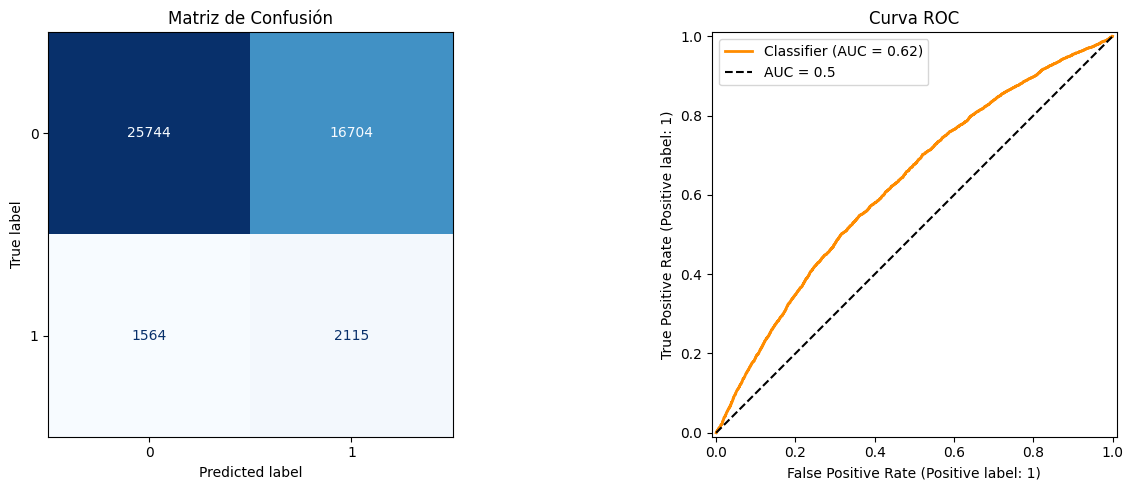

In [63]:
# Se evalua el modelo
metricas_rl = evaluar_modelo(model_rl, X_cv, y_cv, "Regresión Logística", True, 0.5)

**Interpretación**

En el conjunto de validación, el modelo alcanzó un *ROC-AUC de 0.62*, lo que indica una capacidad de discriminación moderada entre clientes en default y no default. En terminos de detección del evento de interés, el modelo logró un *recall de 57%* para la clase default, capturando poco más de la mitad de los clientes que efectivamente incurrieron en incumplimento. 

No obstante, la *precisión asociada a la clase default fue baja (11%)*, lo que refleja un número elevado de falsos positivos. Tal como se observa en la matriz de confusión, una proporción considerable de clientes sanos fue clasificada erróneamente como riesgosa, lo que implicaría un costo operativo elevado desde la perspectiva de negocio.

En conjunto, estos resultados muestran que la Regresión Logística cumple adecuadamente su rol como modelo base, pero presenta limitaciones importantes para capturar la complejidad del problema. La combinación de una capacidad de discriminación moderada y una baja precision sugiere que el modelo no logra representar de forma adecuada relaciones no lineales ni interacciones entre variables.

En consecuencia, los resultados obtenidos justifican avanzar hacia modelos más flexibles, comenzando por enfoques basados en árboles de decisión, con el objetivo de mejorar el desempeño predictivo y reducir el número de falsos positivos sin sacrificar significativamente la capacidad de detección de clientes en default.

### 2. Árbol de Decisión

Se limita la profundidad del árbol a un valor moderado con el objetivo de controlar la complejidad del modelo y reducir el riesgo de sobreajuste, manteniendo al mismo tiempo la capacidad de capturar relaciones no lineales e interacciones entre variables.

In [33]:
#### Árbol de Decisión ####

# se entrena el modelo
model_tree = DecisionTreeClassifier(max_depth=5, random_state=42)
model_tree.fit(X_train, y_train)

,criterion,'gini'
,splitter,'best'
,max_depth,5
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,None
,random_state,42
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,class_weight,None


--- Reporte de Clasificación ---
              precision    recall  f1-score   support

           0       0.92      1.00      0.96     42448
           1       0.67      0.00      0.00      3679

    accuracy                           0.92     46127
   macro avg       0.79      0.50      0.48     46127
weighted avg       0.90      0.92      0.88     46127



C:\Users\juanm\anaconda3\envs\tf_env\lib\site-packages\sklearn\utils\_plotting.py:175: FutureWarning: `**kwargs` is deprecated and will be removed in 1.9. Pass all matplotlib arguments to `curve_kwargs` as a dictionary instead.
  warnings.warn(


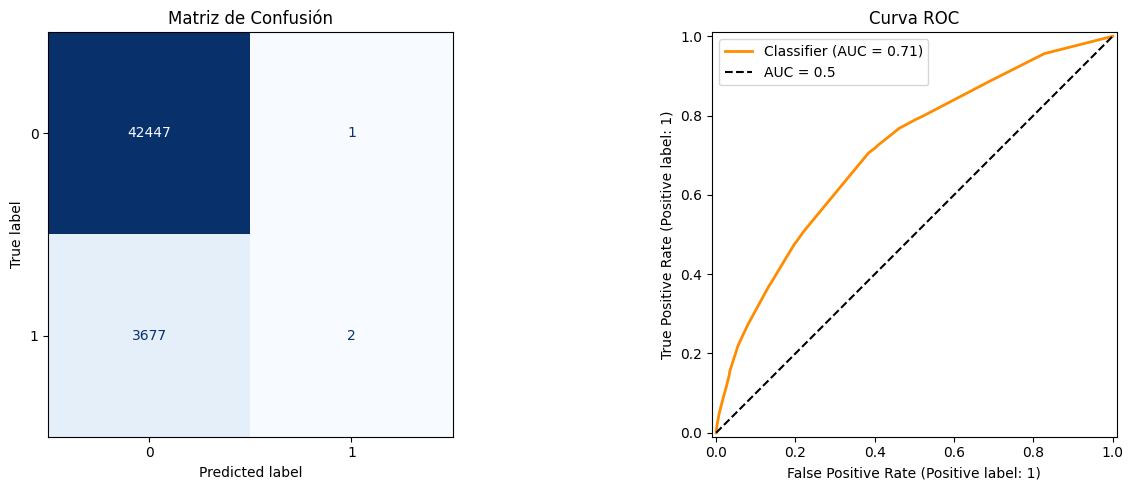

In [64]:
# Evaluación del modelo
metricas_tree = evaluar_modelo(model_tree, X_cv, y_cv, "Árbol de Decisión", True, 0.5)

**Interpretación**

En el conjunto de validación, el modelo alcanzó un *ROC-AUC de 0.71*, lo que representa una mejora significativa en la capacidad de discriminación respecto a la Regresión Logística. Este resultado sugiere que el modelo es capaz de ordenar correctamente a los clientes según su riesgo relativo de incumplimiento.

Sin embargo, al analizar el desempeño en un umbral de clasificación estándar, se observa que el modelo presenta un *recall nulo* para la clase default, identificando únicamente 2 casos de incumplimiento de un total considerable de clientes en default. Este comportamiento se refleja en la matriz de confusión, donde el modelo muestra una tendencia marcada a clasificar a la mayoría de los clientes como no default.

A pesar de ello, la *precision asociada a la clase default es elevada (67%)*, lo que indica que cuando el modelo clasifica a un cliente como riesgoso, dicha predicción suele ser correcta. Este resultado evidencia un enfoque altamente conservador, priorizando la reducción de falsos positivos a costa de no identificar la mayoría de los casos de incumplimiento.

En conjunto, estos resultados muestran que el Árbol de Decisión mejora la capacidad de discriminación global del modelo, pero presenta limitaciones importantes en términos de sensibilidad al evento de interés. Este trade-off pone de manifiesto la necesidad de utilizar modelos más flexibles o enfoques ensamblados que permitan mejorar simultáneamente la identificación de clientes en default y mantener una tasa controlada de falsos positivos.

En consecuencia, los resultados obtenidos justifican avanzar hacia modelos de Gradient Boosting, los cuales combinan múltiples árboles de decisión y suelen ofrecer un mejor equilibrio entre discriminación, recall y precision en problemas de riesgo crediticio.

### 3. XGBoost

El modelo se entrenará utilizando una configuración base, priorizando la estabilidad y la comparabilidad con los modelos anteriores.

- El número de árboles (n_estimators = 200) se coloco con el objetivo de capturar patrones sin sobreajustar.
- La profundidad máxima (max_depth = 5) para que sea consistente con el árbol de decisión y porque controla la complejidad.
- Tasa de aprendizaje (learning_rate = 0.05) se coloco una tasa baja para una aprendizaje gradual y estable.
- (min_child_weight = 100): evita realizar splits sobre poco datos.
- (gamma = 0) para evitar penalizaciones en esta etapa.

In [24]:
#### XGBoost ####

# Se entrena el modelo
model_xgb = xgb.XGBClassifier(
    n_estimators = 200, max_depth = 5, learning_rate = 0.05, gamma = 0, 
    min_child_weight = 100, random_state = 42
)

model_xgb.fit(X_train, y_train)

,objective,'binary:logistic'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,None
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,None


--- Reporte de Clasificación ---
              precision    recall  f1-score   support

           0       0.92      1.00      0.96     42448
           1       0.62      0.01      0.03      3679

    accuracy                           0.92     46127
   macro avg       0.77      0.51      0.49     46127
weighted avg       0.90      0.92      0.88     46127



C:\Users\juanm\anaconda3\envs\tf_env\lib\site-packages\sklearn\utils\_plotting.py:175: FutureWarning: `**kwargs` is deprecated and will be removed in 1.9. Pass all matplotlib arguments to `curve_kwargs` as a dictionary instead.
  warnings.warn(


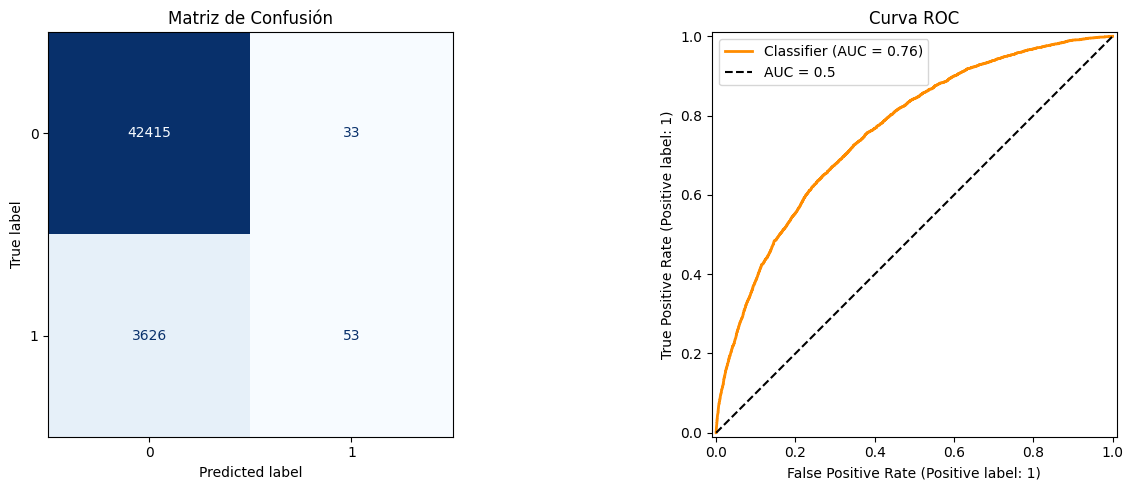

In [66]:
# Evaluación
metricas_xgb = evaluar_modelo(model_xgb, X_cv, y_cv, "XGBoost", True, 0.5)

**Interpretación**

El comportamiento del modelo indica una estrategia de clasificación altamente conservadora. A pesar de contar con el mejor desempeño global (ROC-AUC = 0.76), el modelo presenta un recall extremadamente bajo (0.01), lo que implica que la mayoría de los eventos de default no están siendo capturados.

Por otro lado, la alta precisión (0.62) sugiere que el modelo solo asigna la etiqueta de default cuando existe una alta certeza, minimizando falsos positivos.

### Resumen Desempeño Modelos Base

In [39]:
# Se unifican las métricas para su análisis
metricas_base = pd.concat([
    metricas_rl, metricas_tree, metricas_xgb
]).reset_index(drop = True)

metricas_base

,modelo,ROC-AUC,Recall (default),Precision (default)
0,Regresión Logística,0.624489,0.574884,0.112386
1,Árbol de Decisión,0.709183,0.000544,0.666667
2,XGBoost,0.759069,0.014406,0.616279


Los resultados obtenidos muestran claramente el trade-off entre capacidad discriminativa global y detección efectiva de la clase minoritaria:
- Los modelos más complejos (Árbol y XGBoost) presentan mejor ROC-AUC, pero fallan en capturar defaults bajo configuraciones iniciales.
- La regresión logística, aunque más simple, logra un mejor equilibrio inicial en términos de recall, lo que la convierte en una referencia importante para futuras mejoras.

A pesar de que la *regresión logística* presenta un mejor desempeño inicial en términos de recall, se decide seleccionar *XGBoost* como modelo base para la siguiente etapa del proyecto. 

Esta decisión se fundamenta en:
- Su mayor capacidad de modelar relaciones no lineales, interacciones complejas entre variables y patrones heterogéneos presentes en los datos, lo cual se refleja en el mejor desempeño global medido por ROC-AUC.
- El bajo recall observado en esta etapa no se interpreta como una limitación estructural del modelo, sino como una consecuencia de una configuración conservadora y de la ausencia de técnicas específicas para el manejo del desbalance de clases y del umbral de decisión.

En este contexto, XGBoost ofrece mayor flexibilidad y margen de mejora mediante ajustes dirigidos, lo que lo convierte en el candidato más adecuado para la fase de optimización.

## Optimización del Modelo XGBoost

Se realizará una optimización secuencial, donde cada fase aborda un asepecto especifico del problema. Este enfoque permite entender el impacto de cada ajuste, intepretar el impacto entre hiperparámetros y mantener trazabilidad en las mejoras obtenidas.

### 1. Tratamiento de Desbalance de Clases

Dado el fuerte desbalance en la variable objetivo, se ajusta el hiperparámetro *scale_pos_weight* con el objetivo de penalizar los errores cometidos sobre la clase minoritaria (default).

Dicho hiperparametro tendrá los siguientes escenarios:
- 1: Línea base (Sin ajustar).
- ratio/2: Un ajuste moderado (conservador)
- ratio: El ajuste teorico estándar que igual la importancia de ambas clases
- 2*ratio: Un ajuste agresivo para priorizar el máximo recall (sensibilidad).

Siendo:
$$ratio = \frac{\text{Num\_No\_Default}}{\text{Num\_Default}}$$

In [55]:
# Se calcula el peso inicial de la clase positiva (default)
num_default = len(y_train[y_train == 1])
num_no_default = len(y_train[y_train == 0])
ratio = num_no_default / num_default

# Se genera una lista con valores cercanos y escaldados al ratio
scale_pos_weight = [1, ratio/2, ratio, 2*ratio]

In [67]:
# Se entrenan los modelos y se evaluan
metricas_scale = []

for scale in scale_pos_weight:

    # Se entrena el modelo
    model_xgb_temp = xgb.XGBClassifier(
        n_estimators = 200, max_depth = 5, learning_rate = 0.05, gamma = 0, 
        min_child_weight = 100, scale_pos_weight = scale, random_state = 42
    )
    
    model_xgb_temp.fit(X_train, y_train)
    
    # Se evalua el modelo
    metricas = evaluar_modelo(model_xgb_temp, X_cv, y_cv, "XGBoost", False, 0.5)
    metricas["scale"] = scale

    metricas_scale.append(metricas)

# Se visualizan las metricas generadas
metricas_scale = pd.concat(metricas_scale).reset_index(drop = True)
metricas_scale

,modelo,ROC-AUC,Recall (default),Precision (default),scale
0,XGBoost,0.759069,0.014406,0.616279,1.000000
1,XGBoost,0.758897,0.402555,0.242310,5.681283
2,XGBoost,0.759281,0.673824,0.165267,11.362566
3,XGBoost,0.758962,0.878771,0.119466,22.725132


**Resultados**

- Valores bajos ($scale = 1$) muestran una alta precisión, pero un recall extremadamente bajo, lo que implica que la mayoría de los defaults no son detectados.
- Valores intermedios ($scale \approx 5.7$) logra un aumento relevante del recall, aunque pueden resultar conservadores desde una perspectiva de gestión de riesgos.
- Valores más altos ($scale \approx 11.4$) alcanzan un equilibrio razonable entre_
  + Capacidad de detección ($recall \approx 67%$)
  + Nivel aceptable de falsos positivos ($precision \approx 16%$)
- Valores muy altos ($scale \approx 22.7$) maximizan el recall, pero generan una tasa de falsos positivos elevada, lo cual puede resultar costoso e impráctico en escenarios reales de originación de crédito.

Por tanto, dado que:
- El poder discriminativo del modelo no se ve comprometido, ya que se mantiene estable el ROC-AUC.
- Se logra un balance adecuado entre sensibilidad y precisión.
- Evita un enfoque excesivamente agresivo.

Se selecciona $scale\_pos\_weight \approx 11.36$ como configuración base del modelo XGBoost.

### 2. Ajuste del Umbral de Decisión:

Una vez definido el modelo y ajustado el manejo del desbalance mediante scale_pos_weight, se procede a calibrar el umbral de decisión. Esta etapa permite alinear el comportamiento del modelo con los objetivos del negocio, priorizando la detección de clientes en riesgo de incumplimiento y controlando el nivel de falsos positivos

In [74]:
# Se genera el modelo con la escala seleccionada
model_xgb_vf = xgb.XGBClassifier(
    n_estimators = 200, max_depth = 5, learning_rate = 0.05, gamma = 0, 
    min_child_weight = 100, scale_pos_weight = ratio, random_state = 42
)

model_xgb_vf.fit(X_train, y_train)

# Se genera una lista de los umbrales a probar
umbrales = np.arange(0.1, 1, 0.1)

In [75]:
# Se evalua el modelo con los diferentes umbrales
metricas_umbral = []

for umbral in umbrales:

    metricas = evaluar_modelo(model_xgb_vf, X_cv, y_cv, "XGBoost", False, umbral)
    metricas["umbral"] = umbral

    metricas_umbral.append(metricas)

# Se genera el df
metricas_umbral = pd.concat(metricas_umbral).reset_index(drop = True)
metricas_umbral

,modelo,ROC-AUC,Recall (default),Precision (default),umbral
0,XGBoost,0.759281,0.999185,0.081132,0.1
1,XGBoost,0.759281,0.977711,0.091355,0.2
2,XGBoost,0.759281,0.914107,0.110494,0.3
3,XGBoost,0.759281,0.813536,0.134856,0.4
4,XGBoost,0.759281,0.673824,0.165267,0.5
5,XGBoost,0.759281,0.516445,0.207628,0.6
6,XGBoost,0.759281,0.328622,0.267182,0.7
7,XGBoost,0.759281,0.133460,0.367240,0.8
8,XGBoost,0.759281,0.014134,0.666667,0.9


Tras la comparación de los modelos evaluados, XGBoost se selecciona como modelo final al presentar la mayor capacidad discriminativa global, con un $ROC-AUC \approx 0.76$, superando a la regresión logística y al árbol de decisión. Este desempeño indica una mejor separación entre clientes en default y no default, independientemente del umbral de clasificación.

Una vez definido el modelo, se realizó el ajuste del umbral de decisión para alinear el desempeño del modelo con el objetivo del negocio, manteniendo constante la estructura del modelo. Como era esperado, el ROC-AUC se mantiene estable ($\approx 0.759$), mientras que el umbral controla el trade-off entre recall y precision:

- Umbral 0.3: Recall = 0.91 | Precisión = 0.11
- Umbral 0.5: Recall = 0.67 | Precisión = 0.17
- Umbral 0.7: Recall = 0.33 | Precisión = 0.27

Se selecciona un umbral de 0.3, ya que permite maximizar la detección de clientes en incumplimiento, sacrificando precisión a cambio de una cobertura significativamente mayor de la clase minoritaria. Este enfoque es consistente con un escenario de riesgo crediticio, donde el costo de no identificar un default es más alto que el de generar falsos positivos.

## Evaluación Final del modelo

En esta sección se realiza la evaluación final del modelo seleccionado utilizando el conjunto de prueba, con la finalidad de medir la capacidad de generalización del modelo y obtener una estimación realista de su desempeño en datos no vistos, bajo la configuración final definida a partir del conjunto de entrenamiento y validación.

--- Reporte de Clasificación ---
              precision    recall  f1-score   support

           0       0.98      0.36      0.53     42393
           1       0.11      0.91      0.20      3734

    accuracy                           0.41     46127
   macro avg       0.54      0.63      0.36     46127
weighted avg       0.91      0.41      0.50     46127



C:\Users\juanm\anaconda3\envs\tf_env\lib\site-packages\sklearn\utils\_plotting.py:175: FutureWarning: `**kwargs` is deprecated and will be removed in 1.9. Pass all matplotlib arguments to `curve_kwargs` as a dictionary instead.
  warnings.warn(


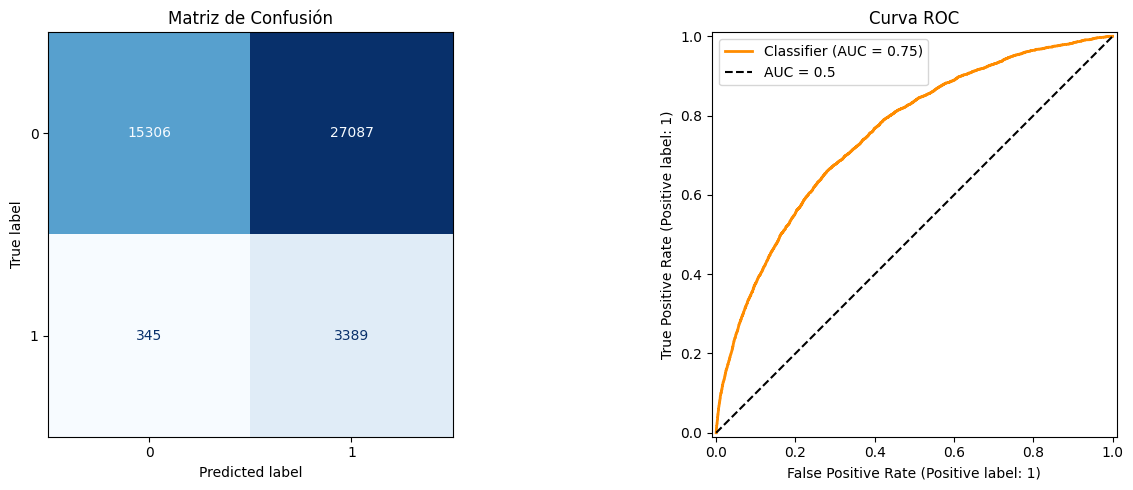

In [80]:
"""
Se evalúa el modelo con el conjunto de prueba y con los hiperpárametros seleccionados
- scale = ratio
- umbral = 0.3
"""
metricas_finales = evaluar_modelo(model_xgb_vf, X_test, y_test, "XGBoost", True, 0.3)

Al evaluar el modelo final de XGBoost sobre el conjunto de prueba, utilizando la configuración definida previamente (escala = 11.36 y umbral de decisión = 0.3), se obtuvieron los siguientes resultados:

- ROC-AUC: 0.754
- Recall (default): 0.908
- Precision (default): 0.111

Estos resultados confirman que el modelo mantiene un desempeño consistente respecto a lo observado en el conjunto de validación, sin evidenciar sobreajuste significativo. En particular, el alto recall para la clase default valida que el modelo es capaz de identificar correctamente la mayoría de los eventos de incumplimiento, lo cual es prioritario en un contexto de riesgo crediticio.

## Conclusión

A lo largo del proyecto se desarrolló un flujo completo de modelado, desde el análisis exploratorio de datos hasta la evaluación final en un conjunto de prueba independiente.

Se compararon tres enfoques de modelado (Regresión Logística, Árbol de Decisión y XGBoost), observándose un claro trade-off entre capacidad discriminativa global y detección efectiva de la clase minoritaria. Aunque la regresión logística mostró un comportamiento inicial estable, el modelo XGBoost fue seleccionado por ofrecer la mejor combinación entre ROC-AUC y recall, además de una mayor flexibilidad para manejar relaciones no lineales y desbalance de clases.

La estrategia de ajuste se centró en modificar el peso de la clase minoritaria y el umbral de decisión, permitiendo desplazar el comportamiento del modelo hacia un escenario conservador, donde se prioriza la detección de defaults aun a costa de una menor precisión.

La evaluación final en el conjunto de prueba confirma que el modelo generaliza adecuadamente y cumple con el objetivo principal del proyecto, quedando listo para ser utilizado como modelo base en un entorno productivo o como punto de partida para futuras optimizaciones, como calibración de probabilidades o análisis de costos.